# 作业3：基于LDA的文本分类
谭天一 
ZY2203511
billytan@buaa.edu.cn

## 1. 实验介绍

用给定的语料库中均匀抽取200个段落（每个段落大于500个词）， 每个段落的标签就是对应段落所属的小说。利用LDA模型对于文本建模，并把每个段落表示为主题分布后进行分类。使用jieba库进行分词，用sklearn库搭建LDA模型。验证与分析分类结果，（1）在不同数量的主题个数下分类性能的变化；（2）以"词"和以"字"为基本单元下分类结果有什么差异。

LDA文本分类模型：
一个语料库有 $D$ 篇文档 $\mathrm{s}，\mathrm{K}$ 个主题 $\mathrm{s}$，
1) 对于每一个主题 $\mathrm{k} \in \mathrm{K}$ ，计算出 $\beta_k$ 在参数 $\beta$ 下的狄利克雷分布；
2) 对于每一篇文档 $d \in D ，$ 计算出 $\vartheta_d$ 在参数 $\alpha$ 下的狄利克雷分布；
3) 对于在文档 $d$ 中的每一个词语 $\mathrm{i}$，计算其主题分布 $z_{d i}$ 的多项分布，计算观察到的某一个词语 $w_{j i}$ 的多项式分布。
通过计算后验概率，更新参数:
$$
\mathrm{p}(\mathrm{z}, \vartheta, \beta \mid \mathrm{w}, \alpha, \mathrm{n})=\frac{p(z, \vartheta, \beta \mid \alpha, n)}{p(w \mid \alpha, n)}
$$

## 2. 实验过程

　<font color='red'> 需要把“cn_stopwords.txt”和jyxstxtqj_downcc文件夹放在与本文件相同的目录下。 </font>

首先加载需要的包。

In [3]:
import os
import re
import codecs
import jieba
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

定义读取数据的函数。
函数说明：读取路径下的所有小说，返回小说名列表label_list和内容列表content_list。调用了data_process(content, stopwords_path)函数，用于对内容进行处理。
另外需要说明的是，这个程序项目由Mac构建，文件路径采用正斜杠'/'，在Windows系统运行请改成'\\'

In [4]:
def load_data(path):
    label_list = []
    content_list = []
    novels = os.listdir(path)
    for novel in novels:
        if 'txt' in novel:  # Mac文件夹中含有.Ds_store，应该滤除
            novel_path = path + '/' + novel
            label_list.append(novel.replace('.txt', ''))
            with codecs.open(novel_path, 'r', encoding='utf-8') as file:
                content = file.read()
            content = data_process(content, stopwords_path)
            content_list.append(content)
    return label_list, content_list

根据stopwords_path路径下的停词列表对content进行处理，剔除一些词。

In [5]:
def data_process(content, stopwords_path):
    with open(stopwords_path, 'r', encoding='utf-8') as file:
        stopwords = file.read().split('\n')
    file.close()
    for stopword in stopwords:
        content = content.replace(stopword, '')
    expand_str = u'[a-zA-Z0-9]+'
    content = re.sub(expand_str, '', content)
    content = content.replace("\n", '')
    content = content.replace(" ", '')
    content = content.replace('\u3000', '')
    return content

定义抽取段落的函数。函数说明：均匀抽取至少200个段落，每个段落至少500词。一共16部小说，每部小说抽取200/16取整等于13个段落。用jieba分词后，每部小说被存储为content_cut，从前到后分为13份，每份one_cut=len(content_cut)/13个词。取每份的前600词作为选取的段落进行存储。

In [6]:
def extract_paragraphs(label_list, content_list):
    paragraphs_word = []
    paragraphs_char = []
    labels = []
    for i in range(len(label_list)):
        label = label_list[i]
        content_cut = jieba.lcut_for_search(content_list[i])
        one_cut = len(content_cut) // 13
        ptr = 0  # 定义一个指针变量，指向选段开始的index
        for j in range(13):
            paragraph = content_cut[ptr:ptr + 600]
            ptr = ptr + one_cut
            # 不能让分词结果以列表形式存在
            paragraph_str = ''
            for word in paragraph:
                paragraph_str += str(word) + " "
            paragraph_str = paragraph_str[:-1]
            paragraphs_word.append(paragraph_str)
            labels.append(label)
            paragraph_char = ''
            for word in paragraph:
                for char in word:
                    paragraph_char += str(char) + " "
            paragraph_char = paragraph_char[:-1]
            paragraphs_char.append(paragraph_char)
    return paragraphs_word, paragraphs_char, labels

接下来正式开始处理。

In [7]:
# 加载数据
stopwords_path = './cn_stopwords.txt'
label_list, content_list = load_data('./jyxstxtqj_downcc')
# 划分段落
paragraphs_word, paragraphs_char, labels = extract_paragraphs(label_list, content_list)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/6m/m802mt453fd2n86m6tb61gdm0000gn/T/jieba.cache
Loading model cost 0.247 seconds.
Prefix dict has been built successfully.


当我们以“词”为基本单元时，运行以下代码：

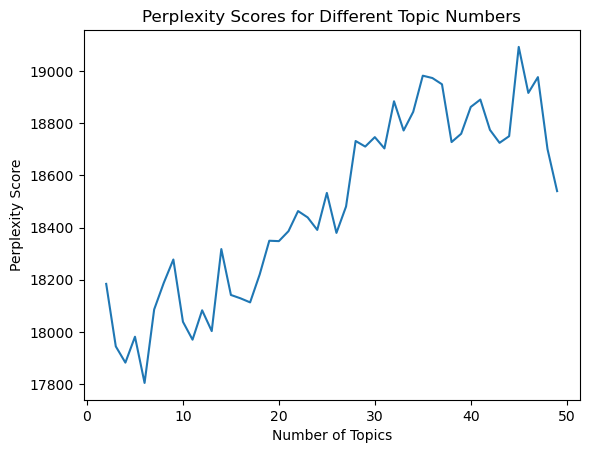

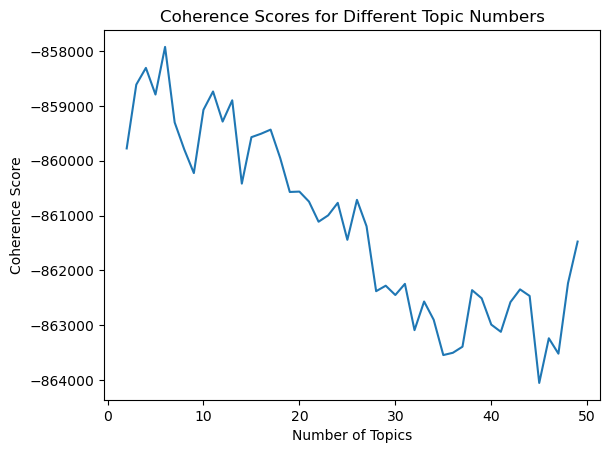

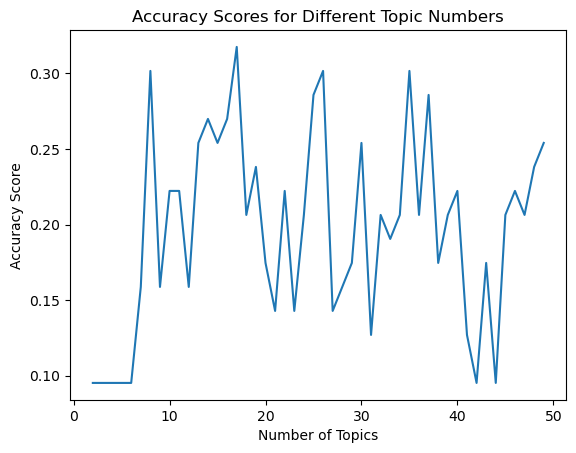

In [8]:
# 以“词”为基本单元时：
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(paragraphs_word)
# explore different topic numbers and calculate perplexity and coherence
topics_range = range(2, 50, 1)
perplexities = []
coherences = []
for k in topics_range:
    lda = LatentDirichletAllocation(n_components=k, random_state=42)
    lda.fit(X)
    perplexity = lda.perplexity(X)
    coherences.append(lda.score(X))
    perplexities.append(perplexity)

# plot perplexities and coherences for different topic numbers
plt.plot(topics_range, perplexities)
plt.title('Perplexity Scores for Different Topic Numbers')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.show()

plt.plot(topics_range, coherences)
plt.title('Coherence Scores for Different Topic Numbers')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)


# train SVM with LDA representations of paragraphs and calculate accuracies for different topic numbers
def train_svm(X_train, y_train, X_test, y_test):
    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return accuracy_score(y_test, y_pred)


accuracies = []
for k in topics_range:
    lda = LatentDirichletAllocation(n_components=k, random_state=42)
    lda.fit(X_train)
    X_train_topics = lda.transform(X_train)
    X_test_topics = lda.transform(X_test)
    accuracy = train_svm(X_train_topics, y_train, X_test_topics, y_test)
    accuracies.append(accuracy)

plt.plot(topics_range, accuracies)
plt.title('Accuracy Scores for Different Topic Numbers')
plt.xlabel('Number of Topics')
plt.ylabel('Accuracy Score')
plt.show()

当我们以“字”为基本单元时，运行以下代码：

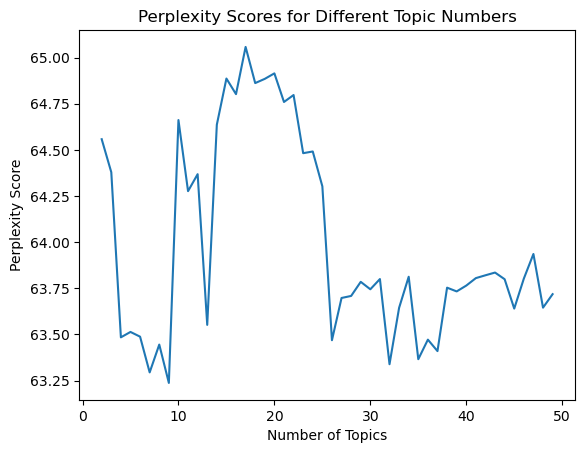

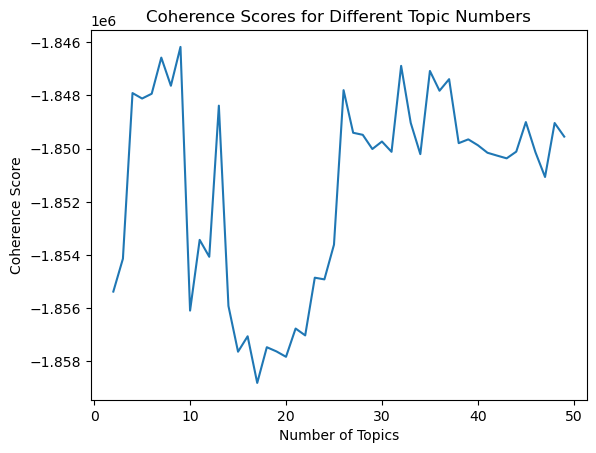

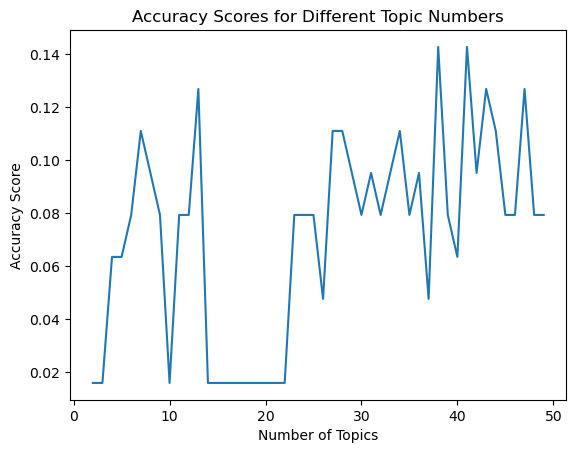

In [10]:
# 以“字”为基本单元时：
# explore different topic numbers and calculate perplexity and coherence
vectorizer = CountVectorizer(analyzer="char")
X = vectorizer.fit_transform(paragraphs_char)
topics_range = range(2, 50, 1)
perplexities = []
coherences = []
for k in topics_range:
    lda = LatentDirichletAllocation(n_components=k, random_state=42)
    lda.fit(X)
    perplexity = lda.perplexity(X)
    coherences.append(lda.score(X))
    perplexities.append(perplexity)

# plot perplexities and coherences for different topic numbers
plt.plot(topics_range, perplexities)
plt.title('Perplexity Scores for Different Topic Numbers')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.show()

plt.plot(topics_range, coherences)
plt.title('Coherence Scores for Different Topic Numbers')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)


# train SVM with LDA representations of paragraphs and calculate accuracies for different topic numbers
def train_svm(X_train, y_train, X_test, y_test):
    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return accuracy_score(y_test, y_pred)


accuracies = []
for k in topics_range:
    lda = LatentDirichletAllocation(n_components=k, random_state=42)
    lda.fit(X_train)
    X_train_topics = lda.transform(X_train)
    X_test_topics = lda.transform(X_test)
    accuracy = train_svm(X_train_topics, y_train, X_test_topics, y_test)
    accuracies.append(accuracy)

plt.plot(topics_range, accuracies)
plt.title('Accuracy Scores for Different Topic Numbers')
plt.xlabel('Number of Topics')
plt.ylabel('Accuracy Score')
plt.show()

## 3. 结果分析

当以“词”为基本单元时，可以看到从大趋势上来说，主题数越少，困惑度越低，一致性越好。而从预测准确率上来看，最高峰出现在10-20之间，约为16左右，基本与16本小说相契合。但预测准确度最高也才30%，可能由于语料库16本书都是武侠小说，题材相近。

当以“字”为基本单元时，可以看到在低主题数和高主题数时，困惑度较低，一致性较好。从预测准确率上来看，低主题数和高主题数时准确率都相对较高。相较来说，主题数在40附近的准确率较高。即使在这种情况下，最高准确率只有越14%，远远低于以“词”为基本单元的情况。